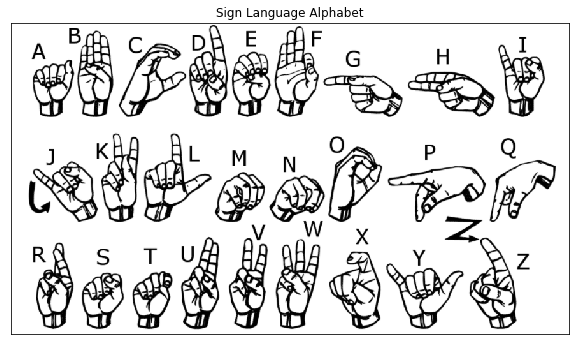

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Update figure size
plt.rcParams["figure.figsize"] = (10,10)

ims = [plt.imread('./american_sign_language.png'), plt.imread('./amer_sign2.png'), plt.imread('./amer_sign3.png')]
plt.title("Sign Language Alphabet")
plt.imshow(ims[0])
plt.xticks([])
plt.yticks([])
plt.show()

In [52]:
def read_data(fname):
    f = open(fname, 'r')
    f.readline()
    
    x = []
    y = []
    
    for line in f:
        line = line.replace("\n", "").split(",")
        label = int(line[0])
        image = line[1:]
        y.append(label)
        x.append(np.array(image, dtype=np.float).reshape(28,28))
    
    
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    # Normalize
    x /= 255.
    x = np.swapaxes(x, 1, 3)
    
    return x, np.array(y)
    

x_train, y_train = read_data('sign_mnist_train.csv')
x_test, y_test = read_data('sign_mnist_test.csv')
print("Number of training images: %d" % y_train.shape[0])
print("Number of test images: %d" % y_test.shape[0])

Number of training images: 27455
Number of test images: 7172


In [53]:
def get_mapping_dictionary(labels):
    mappings = {}
    for x in range(max(labels) + 2):
        mappings[x] = chr(ord('A') + int(x))
    
    
    return mappings

mappings = get_mapping_dictionary(y_train)
print("Labels to Letters: ")
print(mappings)

Labels to Letters: 
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Some random samples with their labels: 


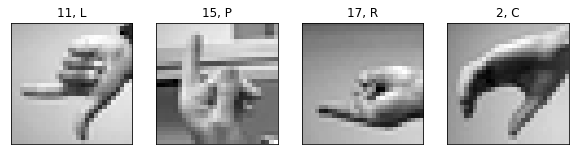

In [54]:
print("Some random samples with their labels: ")
fig, ax = plt.subplots(1,4)

randomind = np.random.choice(len(x_train), 4)
i = 0
plt.xticks([])
plt.yticks([])
for ind in randomind:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title("%d, %s" % (y_train[ind], mappings[y_train[ind]]))
    ax[i].imshow(x_train[ind].squeeze(), cmap='gray')
    i += 1
fig.show()

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix


class Net(nn.Module):
    
    def __init__(self, N, n_input):
        
        super(Net, self).__init__()
        
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(2304, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, N)
        )
        
    def forward(self, x):
            
        x = self.conv_layer(x)
            
        x = x.view(x.size(0), -1)
            
        x = self.fc_layer(x)
            
        return x
        
    

class SignLanguageClassifier(object):
    
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = torch.from_numpy(x_train)
        self.x_test = torch.from_numpy(x_test)
        self.y_train = torch.from_numpy(y_train)
        self.y_test = torch.from_numpy(y_test)
        self.N = 25
        self.n_input = x_train.shape[1]
        self.model = self.get_model()
        self.training_accs = None
        self.test_accs = None
        self.loss = None
    
    def get_model(self):
        return Net(self.N, self.n_input)
    
    def train(self):
        
        training_data = TensorDataset(self.x_train, self.y_train)
        test_data = TensorDataset(self.x_test, self.y_test)
        
        # Batch size
        batch_size = 256
        
        train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
        
        batch_size = 256
        
        
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
        
        # Loss function
        criterion = torch.nn.CrossEntropyLoss()
        
        # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        
        epochs = 15
        
        training_accs = []
        test_accs = []
        loss_tracker = []
        
        for epoch in range(epochs):
            self.model.train()
            for d,t in train_loader:
                
                # Zero out the optimizer
                optimizer.zero_grad()
                
                # Make prediction based on the model
                outputs = self.model(d.float())
                
                
                # Compute the loss
                loss = criterion(outputs, t)
                
                
                # Compute the derivative with respect to params
                loss.backward()
                
                # Update the parameters
                optimizer.step()
            
            # Track the loss at this epoch.
            loss_tracker.append(loss.item())
            
            # Get the training set accuracy
            total = 0
            correct = 0
            
            for d,t in train_loader:
                outputs = self.model(d.float())
                
                _, predicted = torch.max(outputs.data, 1)
                
                total += t.size(0)
                correct += (predicted == t).sum()
                
            training_accs.append(100.*correct / total)
            
            # Get test set accuracy
            total = 0
            correct = 0
            
            for d,t in test_loader:
                outputs = self.model(d.float())
                
                _, predicted = torch.max(outputs.data, 1)
                
                total += t.size(0)
                correct += (predicted == t).sum()
            
            test_accs.append(100.*correct / total)
            
            
            print("Epoch: %d, Training Accuracy: %0.3f, Test Accuracy: %0.3f" %(epoch+1, training_accs[-1], test_accs[-1]))
        
        self.model.eval()
        
        self.training_accs = training_accs
        self.test_accs = test_accs
        self.loss = loss_tracker
    
    def confusion_M(self):
        y_pred_test = self.model(self.x_test.float()).detach().numpy()
        y_pred_test = np.argmax(y_pred_test, axis=1) # Get classes from logits.
        
        return confusion_matrix(y_pred_test, self.y_test.detach().numpy())

In [56]:
slc = SignLanguageClassifier(x_train, x_test, y_train, y_test)

In [57]:
slc.train()

Epoch: 1, Training Accuracy: 4.364, Test Accuracy: 3.583
Epoch: 2, Training Accuracy: 40.830, Test Accuracy: 37.563
Epoch: 3, Training Accuracy: 95.433, Test Accuracy: 83.463
Epoch: 4, Training Accuracy: 98.445, Test Accuracy: 88.107
Epoch: 5, Training Accuracy: 99.949, Test Accuracy: 90.073
Epoch: 6, Training Accuracy: 99.078, Test Accuracy: 91.230
Epoch: 7, Training Accuracy: 99.869, Test Accuracy: 91.049
Epoch: 8, Training Accuracy: 99.745, Test Accuracy: 91.997
Epoch: 9, Training Accuracy: 99.924, Test Accuracy: 91.272
Epoch: 10, Training Accuracy: 99.723, Test Accuracy: 91.313
Epoch: 11, Training Accuracy: 99.934, Test Accuracy: 92.276
Epoch: 12, Training Accuracy: 99.938, Test Accuracy: 91.062
Epoch: 13, Training Accuracy: 99.636, Test Accuracy: 91.007
Epoch: 14, Training Accuracy: 99.501, Test Accuracy: 90.742
Epoch: 15, Training Accuracy: 99.949, Test Accuracy: 93.098


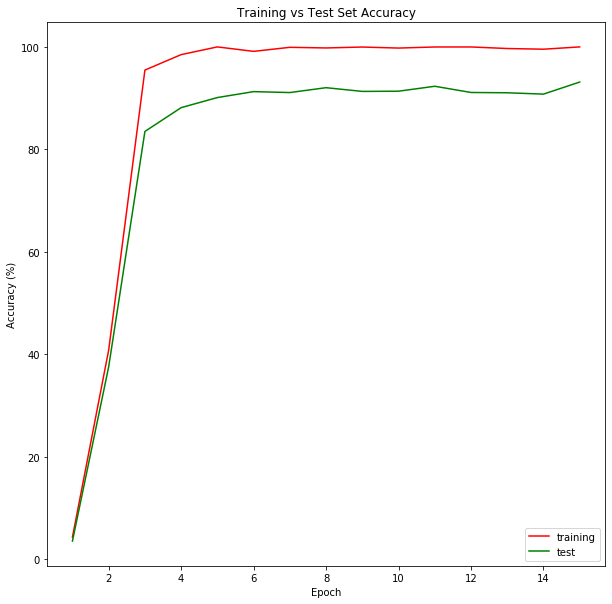

In [58]:
x = np.linspace(1, 15, 15)
plt.title("Training vs Test Set Accuracy")
plt.plot(x, slc.training_accs, 'r-', label='training')
plt.plot(x, slc.test_accs, 'g-', label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='lower right')
plt.show()

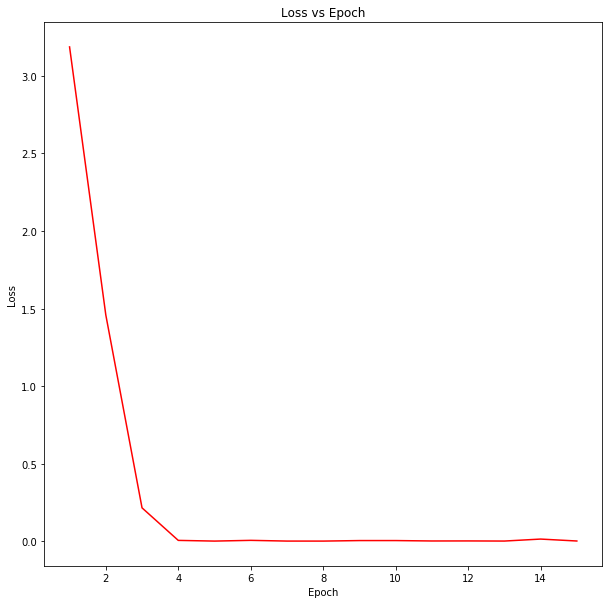

In [71]:
loss = slc.loss
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(x, loss, 'r-')
plt.show()

In [59]:
confusion_M = slc.confusion_M()

In [60]:
print("Class" + "\t" + "Letter")
for key in mappings.keys():
    print(str(key) + "\t" + mappings[key])

Class	Letter
0	A
1	B
2	C
3	D
4	E
5	F
6	G
7	H
8	I
9	J
10	K
11	L
12	M
13	N
14	O
15	P
16	Q
17	R
18	S
19	T
20	U
21	V
22	W
23	X
24	Y
25	Z


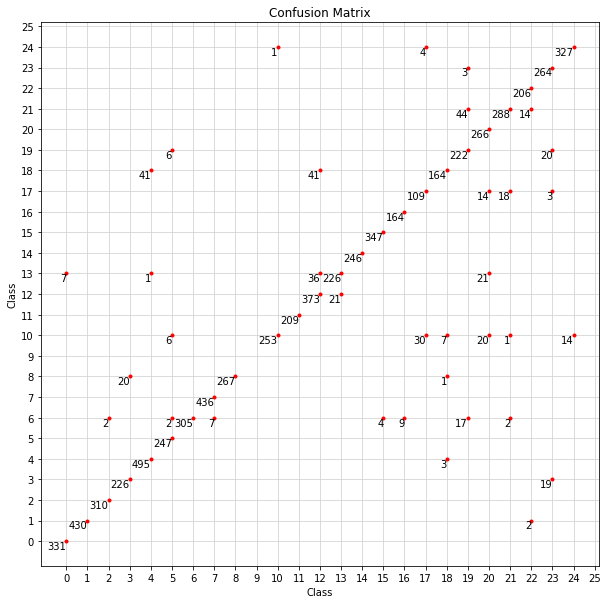

In [122]:
plt.title("Confusion Matrix")
axis = np.linspace(0, 25, 26)
plt.xlabel("Class")
plt.ylabel("Class")
plt.xticks(axis)
plt.yticks(axis)
for i in range(len(confusion_M)):
    for j in range(len(confusion_M[i])):
        
        
        if(confusion_M[i][j] != 0):
            if(i >= 9 and j >= 9):
                plt.plot(i+1,j+1, 'r.')
                plt.text(i+1, j+1, confusion_M[i][j], horizontalalignment='right', verticalalignment='top')
            elif(i >= 9):
                plt.plot(i+1,j, 'r.')
                plt.text(i+1, j, confusion_M[i][j], horizontalalignment='right', verticalalignment='top')
            elif(j >= 9):
                plt.plot(i,j+1, 'r.')
                plt.text(i, j+1, confusion_M[i][j], horizontalalignment='right', verticalalignment='top')
            else:
                plt.plot(i,j, 'r.')
                plt.text(i, j, confusion_M[i][j], horizontalalignment='right', verticalalignment='top')
                
            
plt.grid(b=False, linestyle='-', color='lightgray')
plt.show()

In [62]:
y_pred = slc.model(slc.x_test.float()).detach().numpy()

In [63]:
y_pred_test = []
for obs in y_pred:
    y_pred_test.append(np.argmax(obs))

y_pred_test = np.array(y_pred_test)

In [64]:
correct = 0
total = 0
for i,j in zip(y_pred_test, slc.y_test.detach().numpy()):
    if(i == j):
        correct += 1
    total += 1

print('Test set accuracy: %0.3f Percent' % (correct / total * 100))

Test set accuracy: 93.572 Percent


In [65]:
# Save the model, instead of retraining every time.
torch.save(slc.model.state_dict(), './pretrained.pt')

In [118]:
# Precision and Recall
precision = np.diag(confusion_M)/confusion_M.sum(axis=1)
recall = np.diag(confusion_M)/confusion_M.sum(axis=0)
print("Precision" + '\t' + "Recall" + '\t\t' + 'Letter')
for x in range(len(precision)):
    
    print("%0.2f" % (precision[x]*100), end='\t\t')
    print("%0.2f" % (recall[x]*100), end='\t\t')
    if(x >= 9):
        print(mappings[x+1], end='\n')
    else:
        print(mappings[x], end='\n')
        


Precision	Recall		Letter
97.93		100.00		A
100.00		99.54		B
99.36		100.00		C
91.87		92.24		D
92.18		99.40		E
94.64		100.00		F
100.00		87.64		G
98.42		100.00		H
100.00		92.71		I
99.61		76.44		K
100.00		100.00		L
82.89		94.67		M
91.50		77.66		N
100.00		100.00		O
98.86		100.00		P
94.80		100.00		Q
76.22		75.69		R
93.71		66.67		S
77.62		89.52		T
82.87		100.00		U
93.20		83.24		V
92.79		100.00		W
86.27		98.88		X
95.89		98.49		Y
